In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from statistics import mode
import ast
import msmexplorer as msme
from msmbuilder.utils import load,dump
import itertools
from msmbuilder.featurizer import ContactFeaturizer
from msmbuilder.featurizer import DihedralFeaturizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#XRD Ensemble
#28 4NPQ
#18 4HFI

In [45]:
import seaborn as sns
import ptitprince as pt
sns.set(style="whitegrid",font_scale=1.4)
import matplotlib.collections as clt

In [153]:
def extract_intersubunit_protein_test(traj_note, selection='tmd'):
    default_location = '/home/scottzhuang/pdc/'
    if traj_note.find('ethanol') >= 0: 
        default_skip = 20
    else:
        default_skip = 10
    ref_top_location = 'pdc/msm/F238L_intersubunit/xtc/' + selection + '.pdb'
    ref_traj = md.load(ref_top_location)
    top_location = traj_note + '/' + traj_note + ".protein.pdb"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(default_skip) + ".protein.xtc"
    traj = md.load(default_location + traj_location,top= default_location + top_location)
    topology = traj.topology

    traj0 = traj.atom_slice(topology.select('((chainid 0) and (mass > 2) and resSeq 192 to 246)'))
    traj0prime = traj.atom_slice(topology.select('((chainid 0) and (mass > 2) and resSeq 222 to 280)'))
    traj1 = traj.atom_slice(topology.select('((chainid 1) and (mass > 2) and resSeq 192 to 246)'))
    traj1prime = traj.atom_slice(topology.select('((chainid 1) and (mass > 2) and resSeq 222 to 280)'))
#   traj2 = traj.atom_slice(topology.select('(chainid 2) and backbone'))
#    traj3 = traj.atom_slice(topology.select('(chainid 3) and backbone'))
    traj4 = traj.atom_slice(topology.select('((chainid 4) and (mass > 2) and resSeq 192 to 246)')) 
    traj4prime = traj.atom_slice(topology.select('((chainid 4) and (mass > 2) and resSeq 222 to 280)'))

    traj01 = traj.atom_slice(topology.select('((chainid 0) and (mass > 2) and resSeq 192 to 246) or ((chainid 1) and (mass > 2) and resSeq 222 to 280)'))
    traj12 = traj.atom_slice(topology.select('((chainid 1) and (mass > 2) and resSeq 192 to 246) or ((chainid 2) and (mass > 2) and resSeq 222 to 280)'))
    traj23 = traj.atom_slice(topology.select('((chainid 2) and (mass > 2) and resSeq 192 to 246) or ((chainid 3) and (mass > 2) and resSeq 222 to 280)'))
    traj34 = traj.atom_slice(topology.select('((chainid 3) and (mass > 2) and resSeq 192 to 246) or ((chainid 4) and (mass > 2) and resSeq 222 to 280)'))
    traj40 = traj.atom_slice(topology.select('((chainid 4) and (mass > 2) and resSeq 192 to 246) or ((chainid 0) and (mass > 2) and resSeq 222 to 280)')) 
    traj4.superpose(traj0,0)
    traj0prime.superpose(traj1prime,0)
    traj40.xyz = np.append(traj4.xyz,traj0prime.xyz, axis=1)

    traj40.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
    traj01.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
    traj12.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
    traj23.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
    traj34.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))    

#    traj01.save_pdb(location + traj_note + '/' + traj_note +'.protein.pdb')
    traj01[0].save_pdb('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intersubunit.pdb')
    traj01.save_xtc('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intersubunit_01.xtc')
    traj12.save_xtc('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intersubunit_12.xtc')
    traj23.save_xtc('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intersubunit_23.xtc')
    traj34.save_xtc('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intersubunit_34.xtc')
    traj40.save_xtc('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intersubunit_40.xtc')



In [154]:
def cut_intersubunit(traj_note):
    traj01 = md.load('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit_01.xtc',top='pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit.pdb')
    traj12 = md.load('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit_12.xtc',top='pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit.pdb')
    traj23 = md.load('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit_23.xtc',top='pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit.pdb')
    traj34 = md.load('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit_34.xtc',top='pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit.pdb')
    traj40 = md.load('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit_40.xtc',top='pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intersubunit.pdb')

    with open('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/pdblist.txt', 'w') as file:
        for time in range(0,traj01.n_frames):
            traj01[time].save_pdb('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '_01_' + str(time) + '.pdb')
            file.write(traj_note + '_01_' + str(time) + '.pdb' + '\n')
            traj12[time].save_pdb('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '_12_' + str(time) + '.pdb')
            file.write(traj_note + '_12_' + str(time) + '.pdb' + '\n')
            traj23[time].save_pdb('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '_23_' + str(time) + '.pdb')
            file.write(traj_note + '_23_' + str(time) + '.pdb' + '\n')
            traj34[time].save_pdb('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '_34_' + str(time) + '.pdb')
            file.write(traj_note + '_34_' + str(time) + '.pdb' + '\n')
            traj40[time].save_pdb('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/' + traj_note + '_40_' + str(time) + '.pdb')
            file.write(traj_note + '_40_' + str(time) + '.pdb' + '\n')
        file.close()

In [100]:
traj_notes =  [
              '4HFI_pH46_md4','4HFI_pH46_md5','4HFI_pH46_md6',
        '4HFI_pH46_md7','4HFI_pH46_md8','4HFI_pH46_md9',
                '4HFI_F238L_pH46_md7','4HFI_F238L_pH46_md8','4HFI_F238L_pH46_md9',
        '4HFI_F238L_pH46_md4','4HFI_F238L_pH46_md5','4HFI_F238L_pH46_md6',
              '4HFI_I233T_pH46_md4','4HFI_I233T_pH46_md5','4HFI_I233T_pH46_md6',
        '4HFI_I233T_pH46_md7','4HFI_I233T_pH46_md8','4HFI_I233T_pH46_md9',
                '4HFI_F238LI233T_pH46_md4','4HFI_F238LI233T_pH46_md5','4HFI_F238LI233T_pH46_md6',
            '4HFI_F238LI233T_pH46_md7','4HFI_F238LI233T_pH46_md8','4HFI_F238LI233T_pH46_md9']


In [101]:
traj_notess =  [
              ['4HFI_pH46_md4','4HFI_pH46_md5','4HFI_pH46_md6'],
        ['4HFI_pH46_md7','4HFI_pH46_md8','4HFI_pH46_md9'],
                ['4HFI_F238L_pH46_md7','4HFI_F238L_pH46_md8','4HFI_F238L_pH46_md9'],
        ['4HFI_F238L_pH46_md4','4HFI_F238L_pH46_md5','4HFI_F238L_pH46_md6'],
              ['4HFI_I233T_pH46_md4','4HFI_I233T_pH46_md5','4HFI_I233T_pH46_md6'],
        ['4HFI_I233T_pH46_md7','4HFI_I233T_pH46_md8','4HFI_I233T_pH46_md9'],
                ['4HFI_F238LI233T_pH46_md4','4HFI_F238LI233T_pH46_md5','4HFI_F238LI233T_pH46_md6'],
            ['4HFI_F238LI233T_pH46_md7','4HFI_F238LI233T_pH46_md8','4HFI_F238LI233T_pH46_md9']]


In [157]:
traj_notes = ['4HFI_pH46_ethanol_md1','4HFI_pH46_ethanol_md2','4HFI_pH46_ethanol_md3',
                '4HFI_F238L_pH46_ethanol_md1','4HFI_F238L_pH46_ethanol_md4','4HFI_F238L_pH46_ethanol_md5','4HFI_F238L_pH46_ethanol_md6',
                '4HFI_F238LI233T_pH46_ethanol_md1','4HFI_F238LI233T_pH46_ethanol_md2','4HFI_F238LI233T_pH46_ethanol_md3',
                '4HFI_F238LI233T_pH46_ethanol_md4','4HFI_F238LI233T_pH46_ethanol_md5','4HFI_F238LI233T_pH46_ethanol_md6',
                '4HFI_I233T_pH46_ethanol_md1','4HFI_I233T_pH46_ethanol_md2','4HFI_I233T_pH46_ethanol_md3']

In [156]:
traj_notess = [['4HFI_pH46_ethanol_md1','4HFI_pH46_ethanol_md2','4HFI_pH46_ethanol_md3'],
                ['4HFI_F238L_pH46_ethanol_md1','4HFI_F238L_pH46_ethanol_md4','4HFI_F238L_pH46_ethanol_md5','4HFI_F238L_pH46_ethanol_md6'],
                ['4HFI_I233T_pH46_ethanol_md1','4HFI_I233T_pH46_ethanol_md2','4HFI_I233T_pH46_ethanol_md3'],
                              ['4HFI_F238LI233T_pH46_ethanol_md1','4HFI_F238LI233T_pH46_ethanol_md2','4HFI_F238LI233T_pH46_ethanol_md3'],
                ['4HFI_F238LI233T_pH46_ethanol_md4','4HFI_F238LI233T_pH46_ethanol_md5','4HFI_F238LI233T_pH46_ethanol_md6'],]

In [158]:
import os
for traj_note in traj_notes:
    try:
        os.mkdir('pdc/mdpocket/intersubunit/ethanol/' + traj_note)
    except:
        print('already exist')

already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist
already exist


In [159]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(extract_intersubunit_protein_test)(traj_note) for traj_note in traj_notes)
Parallel(n_jobs=num_cores)(delayed(cut_intersubunit)(traj_note) for traj_note in traj_notes)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [116]:
pocket_ensemble = pd.DataFrame(columns=['snapshot', 'pock_volume', 'pock_asa', 'pock_pol_asa', 'pock_apol_asa',
       'pock_asa22', 'pock_pol_asa22', 'pock_apol_asa22', 'nb_AS',
       'mean_as_ray', 'mean_as_solv_acc', 'apol_as_prop', 'mean_loc_hyd_dens',
       'hydrophobicity_score', 'volume_score', 'polarity_score',
       'charge_score', 'prop_polar_atm', 'as_density', 'as_max_dst', 'ALA',
       'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
       'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL','subunit','traj_note','system','traj_time'])
for traj_notes in traj_notess:
    for traj_note in traj_notes:
        pocket_data = pd.read_table('pdc/mdpocket/' + traj_note + '/mdpout_descriptors.txt',sep='\s+')
        pocket_data['subunit'] = pocket_data.snapshot%5
        pocket_data['traj_note'] = traj_note
        pocket_data['system'] = traj_notes[0]
        pocket_data['traj_time'] = pocket_data.snapshot//5
        pocket_ensemble = pocket_ensemble.append(pocket_data,ignore_index=True)


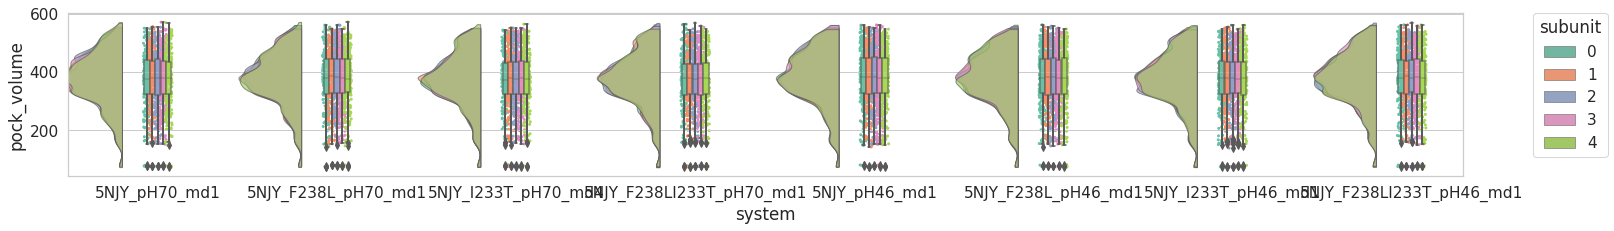

In [77]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature ,hue='subunit', data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


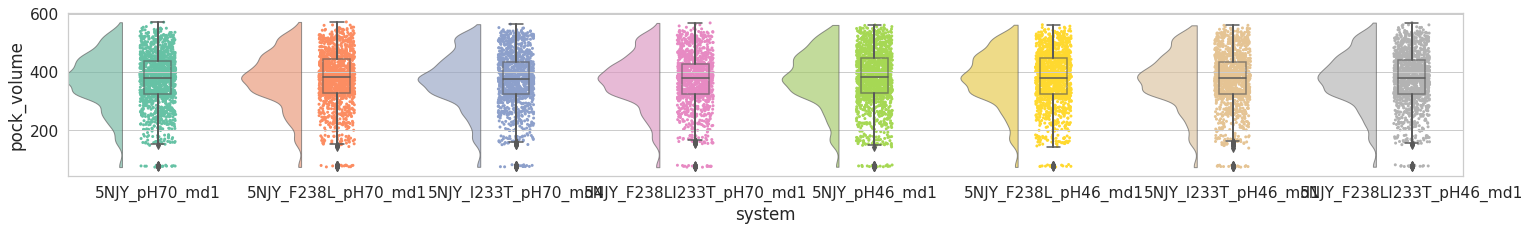

In [78]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


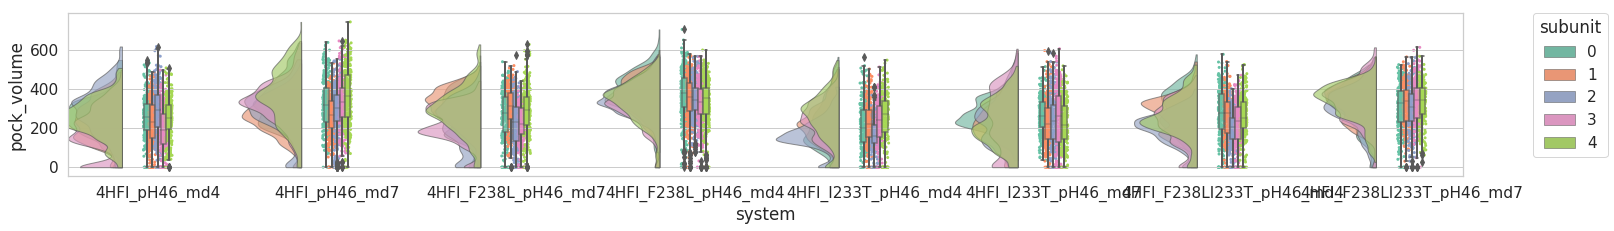

In [120]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature ,hue='subunit', data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


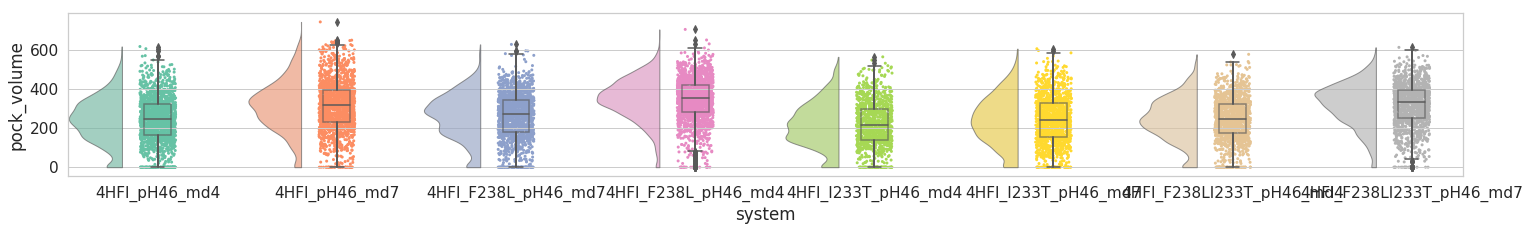

In [119]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


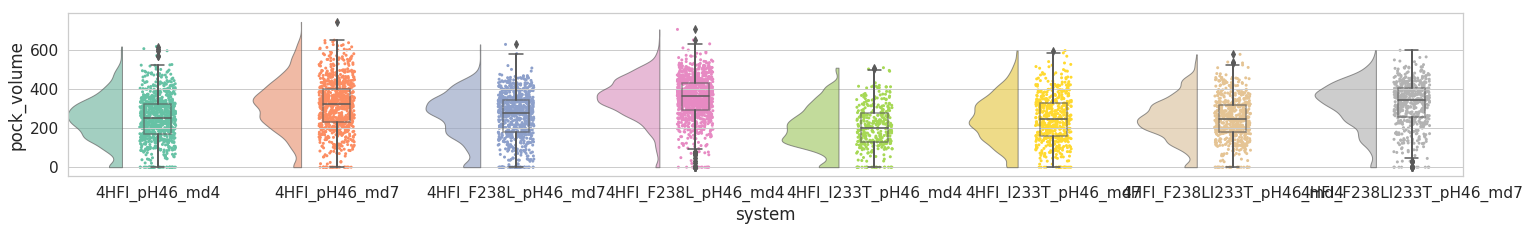

In [118]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble[pocket_ensemble.traj_time > 50],  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


In [160]:
import os
for traj_note in traj_notes:
    try:
        os.mkdir('pdc/mdpocket/intrasubunit/ethanol/' + traj_note)
    except:
        print('already exist')

In [161]:
def extract_intrasubunit_protein_test(traj_note, selection='tmd'):
    default_location = '/home/scottzhuang/pdc/'
    if traj_note.find('ethanol') >= 0: 
        default_skip = 20
    else:
        default_skip = 10
    ref_top_location = 'pdc/msm/F238L_subunit/xtc/tmd.pdb'
    ref_traj = md.load(ref_top_location)
    top_location = traj_note + '/' + traj_note + ".protein.pdb"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(default_skip) + ".protein.xtc"
    traj = md.load(default_location + traj_location,top= default_location + top_location)
    topology = traj.topology

    traj0 = traj.atom_slice(topology.select('(chainid 0) and (mass > 2) and resSeq 192 to 315'))
    traj1 = traj.atom_slice(topology.select('(chainid 1) and (mass > 2) and resSeq 192 to 315'))
    traj2 = traj.atom_slice(topology.select('(chainid 2) and (mass > 2) and resSeq 192 to 315'))
    traj3 = traj.atom_slice(topology.select('(chainid 3) and (mass > 2) and resSeq 192 to 315'))
    traj4 = traj.atom_slice(topology.select('(chainid 4) and (mass > 2) and resSeq 192 to 315'))

    traj4.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
    traj0.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
    traj1.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
    traj2.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
    traj3.superpose(ref_traj,0,atom_indices=ref_traj.topology.select('name CA'))
#    traj01.save_pdb(location + traj_note + '/' + traj_note +'.protein.pdb')
    traj0[0].save_pdb('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intrasubunit.pdb')
    traj1.save_xtc('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intrasubunit_01.xtc')
    traj2.save_xtc('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intrasubunit_12.xtc')
    traj3.save_xtc('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intrasubunit_23.xtc')
    traj4.save_xtc('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intrasubunit_34.xtc')
    traj0.save_xtc('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.' + selection + '.intrasubunit_40.xtc')



In [166]:
def cut_intrasubunit(traj_note):
    traj01 = md.load('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit_01.xtc',top='pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit.pdb')
    traj12 = md.load('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit_12.xtc',top='pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit.pdb')
    traj23 = md.load('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit_23.xtc',top='pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit.pdb')
    traj34 = md.load('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit_34.xtc',top='pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit.pdb')
    traj40 = md.load('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit_40.xtc',top='pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '.tmd.intrasubunit.pdb')

    with open('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/pdblist.txt', 'w') as file:
        for time in range(0,traj01.n_frames):
            traj01[time].save_pdb('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '_01_' + str(time) + '.pdb')
            file.write(traj_note + '_01_' + str(time) + '.pdb' + '\n')
            traj12[time].save_pdb('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '_12_' + str(time) + '.pdb')
            file.write(traj_note + '_12_' + str(time) + '.pdb' + '\n')
            traj23[time].save_pdb('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '_23_' + str(time) + '.pdb')
            file.write(traj_note + '_23_' + str(time) + '.pdb' + '\n')
            traj34[time].save_pdb('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '_34_' + str(time) + '.pdb')
            file.write(traj_note + '_34_' + str(time) + '.pdb' + '\n')
            traj40[time].save_pdb('pdc/mdpocket/intrasubunit/ethanol/' + traj_note + '/' + traj_note + '_40_' + str(time) + '.pdb')
            file.write(traj_note + '_40_' + str(time) + '.pdb' + '\n')
        file.close()

In [167]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
#Parallel(n_jobs=num_cores)(delayed(extract_intrasubunit_protein_test)(traj_note) for traj_note in traj_notes)
Parallel(n_jobs=num_cores)(delayed(cut_intrasubunit)(traj_note) for traj_note in traj_notes)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [70]:
traj_notes =  [
              '4HFI_pH46_md4','4HFI_pH46_md5','4HFI_pH46_md6',
        '4HFI_pH46_md7','4HFI_pH46_md8','4HFI_pH46_md9',
                '4HFI_F238L_pH46_md7','4HFI_F238L_pH46_md8','4HFI_F238L_pH46_md9',
        '4HFI_F238L_pH46_md4','4HFI_F238L_pH46_md5','4HFI_F238L_pH46_md6',
              '4HFI_I233T_pH46_md4','4HFI_I233T_pH46_md5','4HFI_I233T_pH46_md6',
        '4HFI_I233T_pH46_md7','4HFI_I233T_pH46_md8','4HFI_I233T_pH46_md9',
                '4HFI_F238LI233T_pH46_md4','4HFI_F238LI233T_pH46_md5','4HFI_F238LI233T_pH46_md6',
            '4HFI_F238LI233T_pH46_md7','4HFI_F238LI233T_pH46_md8','4HFI_F238LI233T_pH46_md9']


In [79]:
traj_notess =  [
              ['4HFI_pH46_md4','4HFI_pH46_md5','4HFI_pH46_md6'],
        ['4HFI_pH46_md7','4HFI_pH46_md8','4HFI_pH46_md9'],
                ['4HFI_F238L_pH46_md7','4HFI_F238L_pH46_md8','4HFI_F238L_pH46_md9'],
        ['4HFI_F238L_pH46_md4','4HFI_F238L_pH46_md5','4HFI_F238L_pH46_md6'],
              ['4HFI_I233T_pH46_md4','4HFI_I233T_pH46_md5','4HFI_I233T_pH46_md6'],
        ['4HFI_I233T_pH46_md7','4HFI_I233T_pH46_md8','4HFI_I233T_pH46_md9'],
                ['4HFI_F238LI233T_pH46_md4','4HFI_F238LI233T_pH46_md5','4HFI_F238LI233T_pH46_md6'],
            ['4HFI_F238LI233T_pH46_md7','4HFI_F238LI233T_pH46_md8','4HFI_F238LI233T_pH46_md9']]


In [72]:
traj_notes = ['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3',
              '5NJY_F238L_pH70_md1','5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3',
              '5NJY_I233T_pH70_md4','5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3',
              '5NJY_F238LI233T_pH70_md1','5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3',
              '5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3',
              '5NJY_F238L_pH46_md1','5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3',
              '5NJY_I233T_pH46_md1','5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3',
              '5NJY_F238LI233T_pH46_md1','5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3']

In [87]:
traj_notess = [['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3'],
              ['5NJY_F238L_pH70_md1','5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3'],
              ['5NJY_I233T_pH70_md4','5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3'],
              ['5NJY_F238LI233T_pH70_md1','5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3'],
              ['5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3'],
              ['5NJY_F238L_pH46_md1','5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3'],
              ['5NJY_I233T_pH46_md1','5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3'],
              ['5NJY_F238LI233T_pH46_md1','5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3']]

In [69]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(extract_intrasubunit_protein_test)(traj_note) for traj_note in traj_notes)
Parallel(n_jobs=num_cores)(delayed(cut_intrasubunit)(traj_note) for traj_note in traj_notes)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [88]:
pocket_ensemble = pd.DataFrame(columns=['snapshot', 'pock_volume', 'pock_asa', 'pock_pol_asa', 'pock_apol_asa',
       'pock_asa22', 'pock_pol_asa22', 'pock_apol_asa22', 'nb_AS',
       'mean_as_ray', 'mean_as_solv_acc', 'apol_as_prop', 'mean_loc_hyd_dens',
       'hydrophobicity_score', 'volume_score', 'polarity_score',
       'charge_score', 'prop_polar_atm', 'as_density', 'as_max_dst', 'ALA',
       'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
       'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL','subunit','traj_note','system','traj_time'])
for traj_notes in traj_notess:
    for traj_note in traj_notes:
        pocket_data = pd.read_table('pdc/mdpocket/intrasubunit/' + traj_note + '/mdpout_descriptors.txt',sep='\s+')
        pocket_data['subunit'] = pocket_data.snapshot%5
        pocket_data['traj_note'] = traj_note
        pocket_data['system'] = traj_notes[0]
        pocket_data['traj_time'] = pocket_data.snapshot//5

        pocket_ensemble = pocket_ensemble.append(pocket_data,ignore_index=True)

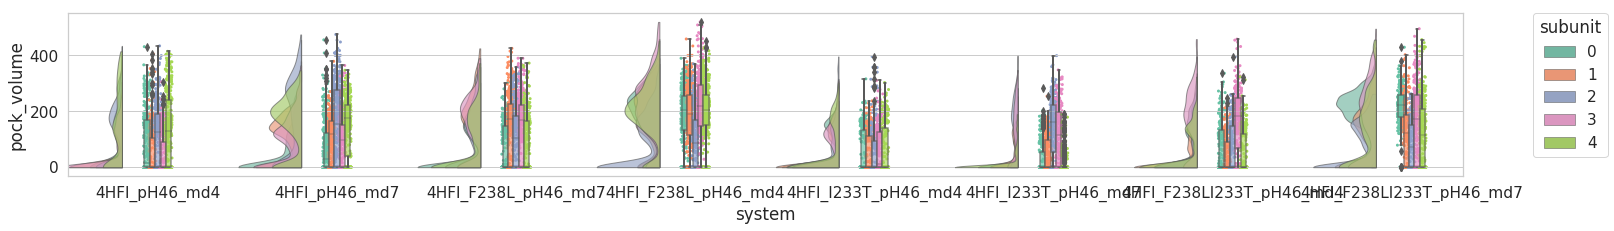

In [84]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature ,hue='subunit', data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


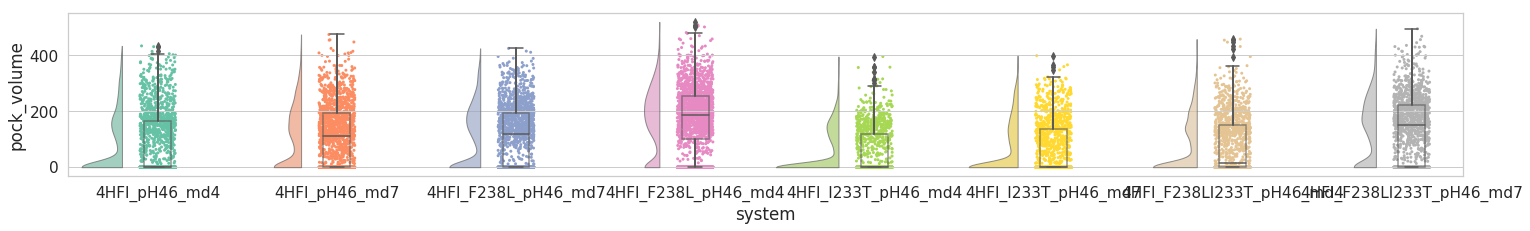

In [86]:
for feature in pocket_ensemble.columns[1:]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


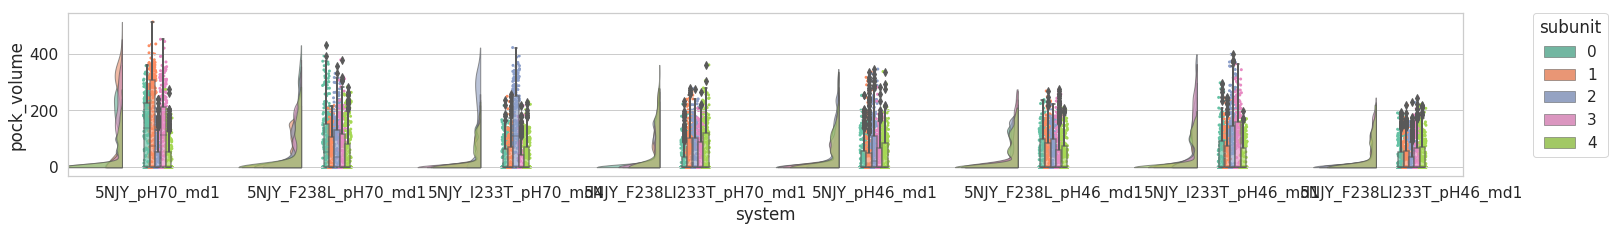

In [89]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature ,hue='subunit', data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


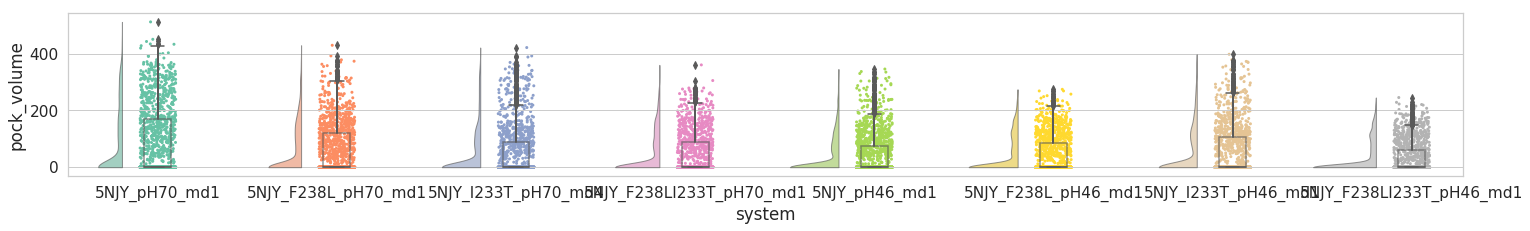

In [94]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


In [70]:
traj_notes =  [
              '4HFI_pH46_md4','4HFI_pH46_md5','4HFI_pH46_md6',
        '4HFI_pH46_md7','4HFI_pH46_md8','4HFI_pH46_md9',
                '4HFI_F238L_pH46_md7','4HFI_F238L_pH46_md8','4HFI_F238L_pH46_md9',
        '4HFI_F238L_pH46_md4','4HFI_F238L_pH46_md5','4HFI_F238L_pH46_md6',
              '4HFI_I233T_pH46_md4','4HFI_I233T_pH46_md5','4HFI_I233T_pH46_md6',
        '4HFI_I233T_pH46_md7','4HFI_I233T_pH46_md8','4HFI_I233T_pH46_md9',
                '4HFI_F238LI233T_pH46_md4','4HFI_F238LI233T_pH46_md5','4HFI_F238LI233T_pH46_md6',
            '4HFI_F238LI233T_pH46_md7','4HFI_F238LI233T_pH46_md8','4HFI_F238LI233T_pH46_md9']


In [121]:
traj_notess =  [
              ['4HFI_pH46_md4','4HFI_pH46_md5','4HFI_pH46_md6'],
        ['4HFI_pH46_md7','4HFI_pH46_md8','4HFI_pH46_md9'],
                ['4HFI_F238L_pH46_md7','4HFI_F238L_pH46_md8','4HFI_F238L_pH46_md9'],
        ['4HFI_F238L_pH46_md4','4HFI_F238L_pH46_md5','4HFI_F238L_pH46_md6'],
              ['4HFI_I233T_pH46_md4','4HFI_I233T_pH46_md5','4HFI_I233T_pH46_md6'],
        ['4HFI_I233T_pH46_md7','4HFI_I233T_pH46_md8','4HFI_I233T_pH46_md9'],
                ['4HFI_F238LI233T_pH46_md4','4HFI_F238LI233T_pH46_md5','4HFI_F238LI233T_pH46_md6'],
            ['4HFI_F238LI233T_pH46_md7','4HFI_F238LI233T_pH46_md8','4HFI_F238LI233T_pH46_md9']]


In [72]:
traj_notes = ['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3',
              '5NJY_F238L_pH70_md1','5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3',
              '5NJY_I233T_pH70_md4','5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3',
              '5NJY_F238LI233T_pH70_md1','5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3',
              '5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3',
              '5NJY_F238L_pH46_md1','5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3',
              '5NJY_I233T_pH46_md1','5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3',
              '5NJY_F238LI233T_pH46_md1','5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3']

In [126]:
traj_notess = [['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3'],
              ['5NJY_F238L_pH70_md1','5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3'],
              ['5NJY_I233T_pH70_md4','5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3'],
              ['5NJY_F238LI233T_pH70_md1','5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3'],
              ['5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3'],
              ['5NJY_F238L_pH46_md1','5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3'],
              ['5NJY_I233T_pH46_md1','5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3'],
              ['5NJY_F238LI233T_pH46_md1','5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3']]

In [127]:
pocket_ensemble = pd.DataFrame(columns=['snapshot', 'pock_volume', 'pock_asa', 'pock_pol_asa', 'pock_apol_asa',
       'pock_asa22', 'pock_pol_asa22', 'pock_apol_asa22', 'nb_AS',
       'mean_as_ray', 'mean_as_solv_acc', 'apol_as_prop', 'mean_loc_hyd_dens',
       'hydrophobicity_score', 'volume_score', 'polarity_score',
       'charge_score', 'prop_polar_atm', 'as_density', 'as_max_dst', 'ALA',
       'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
       'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL','subunit','traj_note','system','traj_time'])
for traj_notes in traj_notess:
    for traj_note in traj_notes:
        pocket_data = pd.read_table('pdc/mdpocket/intersubunit/' + traj_note + '/mdpout_descriptors.txt',sep='\s+')
        pocket_data['subunit'] = pocket_data.snapshot%5
        pocket_data['traj_note'] = traj_note
        pocket_data['system'] = traj_notes[0]
        pocket_data['traj_time'] = pocket_data.snapshot//5

        pocket_ensemble = pocket_ensemble.append(pocket_data,ignore_index=True)

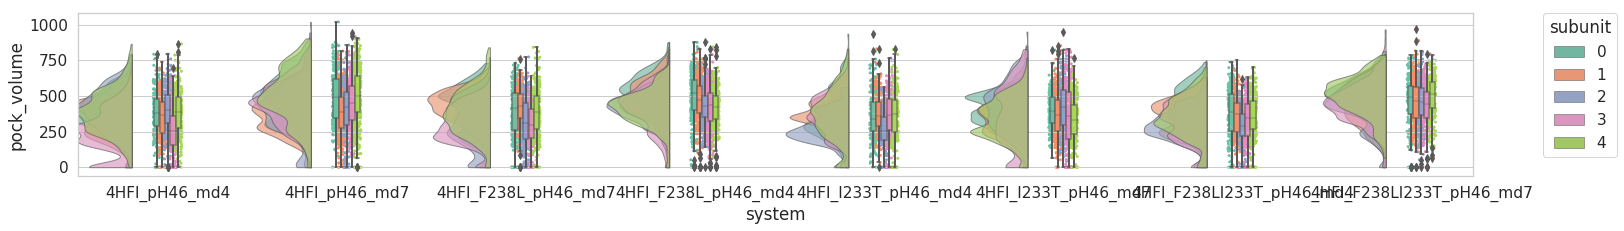

In [123]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature ,hue='subunit', data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


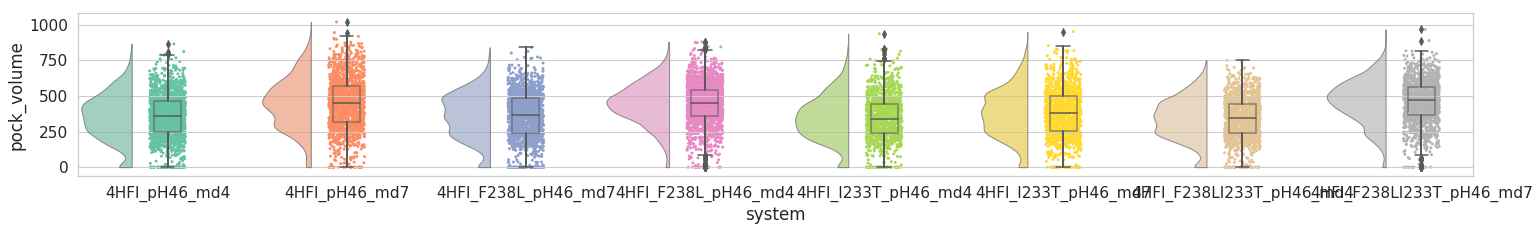

In [125]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


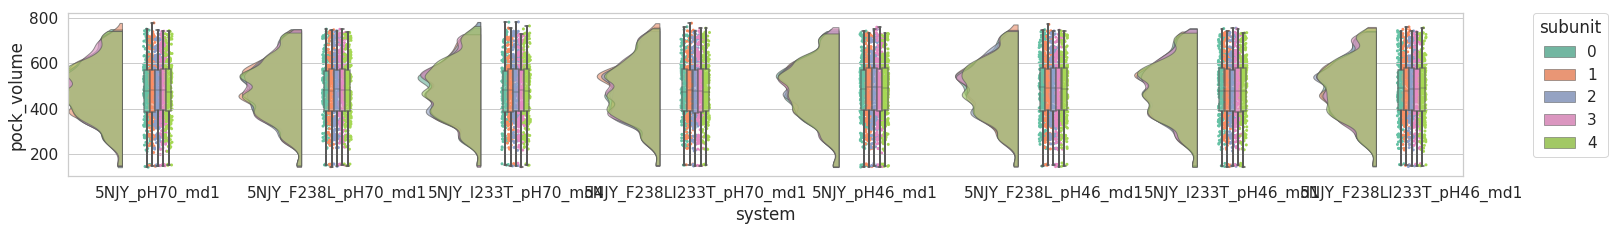

In [128]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature ,hue='subunit', data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


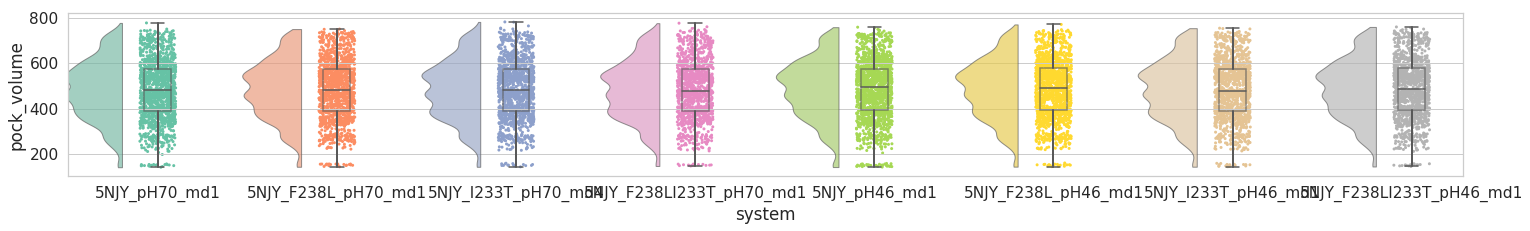

In [129]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


In [146]:
pocket_ensemble = pd.DataFrame(columns=['snapshot', 'pock_volume', 'pock_asa', 'pock_pol_asa', 'pock_apol_asa',
       'pock_asa22', 'pock_pol_asa22', 'pock_apol_asa22', 'nb_AS',
       'mean_as_ray', 'mean_as_solv_acc', 'apol_as_prop', 'mean_loc_hyd_dens',
       'hydrophobicity_score', 'volume_score', 'polarity_score',
       'charge_score', 'prop_polar_atm', 'as_density', 'as_max_dst', 'ALA',
       'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
       'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL','subunit','traj_note','system','traj_time'])
for traj_notes in traj_notess:
    for traj_note in traj_notes:
        pocket_data = pd.read_table('pdc/mdpocket/intersubunit/ethanol/' + traj_note + '/mdpout_descriptors.txt',sep='\s+')
        pocket_data['subunit'] = pocket_data.snapshot%5
        pocket_data['traj_note'] = traj_note
        pocket_data['system'] = traj_notes[0]
        pocket_data['traj_time'] = pocket_data.snapshot//5

        pocket_ensemble = pocket_ensemble.append(pocket_data,ignore_index=True)

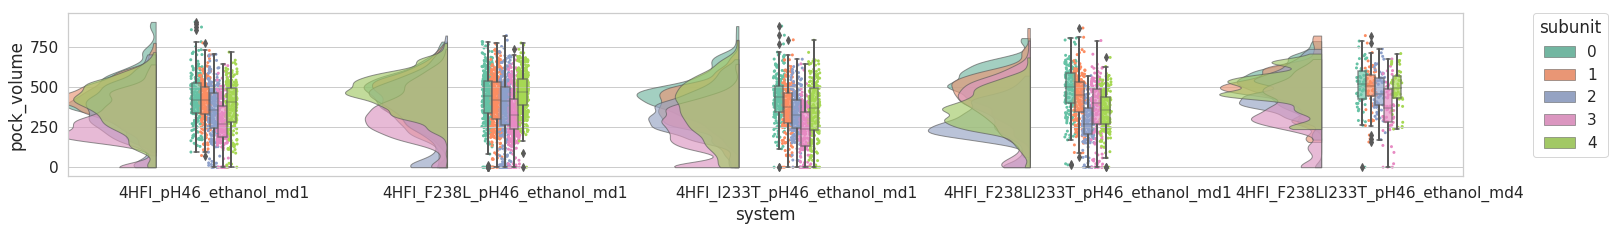

In [148]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature ,hue='subunit', data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)


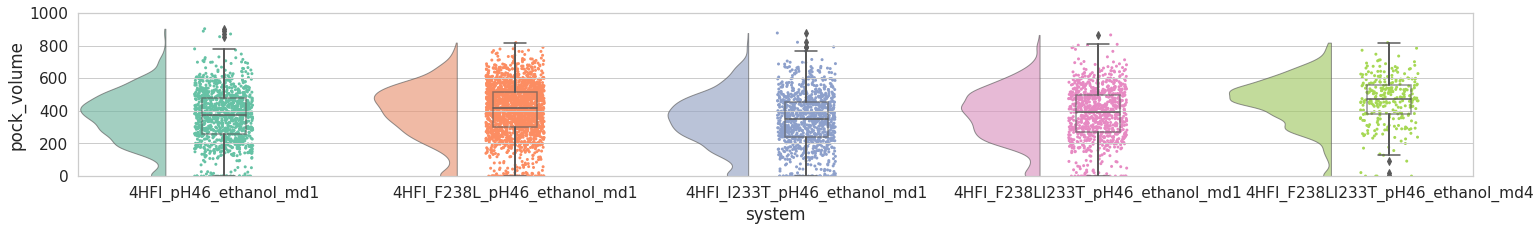

In [152]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble,  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)
    ax.set_ylim(0,1000)

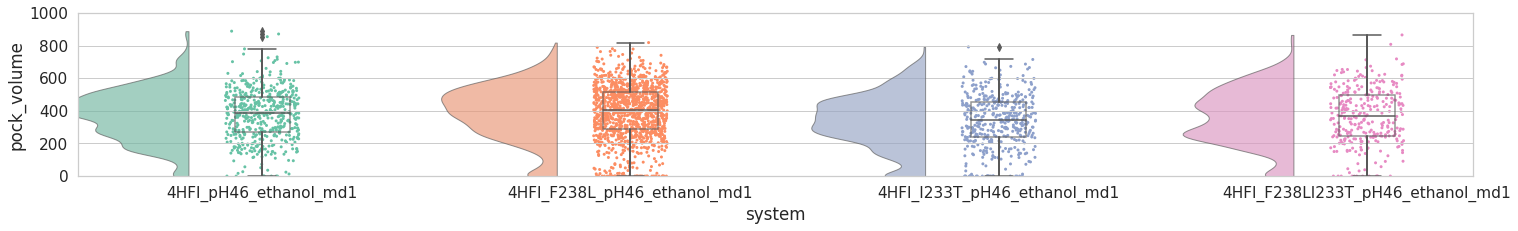

In [151]:
for feature in pocket_ensemble.columns[1:2]:
    fig, ax = plt.subplots(figsize=(25, 3))

    pt.RainCloud(x = 'system', y = feature, data = pocket_ensemble[pocket_ensemble.traj_time>40],  
        palette = 'Set2', bw = .2,width_viol = .7,ax=ax,alpha = .65,dodge = True,pointplot=False)
    #    group = md_data_235.groupby(['system'],sort=False)[feature]
    #    mean = group.mean()
    #    errors = group.sem()
    #    mean.plot.bar(yerr=errors,ax=ax)
    ax.set_ylim(0,1000)